### 📦 1 | Install & Import Required Packages
---

**1.1 | Install Required Packages**

In [19]:
!pip install biopython
!pip install plotnine

**1.2 | Import Required Packages**

In [20]:
from    Bio import Entrez
import  pandas as pd
from    datetime import datetime
from    plotnine import *
from    mizani.formatters import comma_format

### 🚰  2 | Query PubMed API for Publication Counts
---

In [21]:
def fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year):
    """
    Fetches publication counts from PubMed for multiple search terms over a range of years.

    :param search_terms: Dictionary of search terms (diseases) and their PubMed query strings.
    :param start_year: Start year for the data collection.
    :param end_year: End year for the data collection.
    :return: DataFrame with years as rows and diseases as columns, containing publication counts.
    """
    publication_counts = {term: [] for term in search_terms}
    years = range(start_year, end_year + 1)
    Entrez.email = "rory@eudemo.co"

    for year in years:
        for term, query in search_terms.items():
            # Constructing the query with the search term and year
            full_query = f"{query} AND ({year}[Date - Publication])"
            try:
                handle = Entrez.esearch(db="pubmed", term=full_query, retmax=100000)
                record = Entrez.read(handle)
                count = int(record.get("Count", 0))
                publication_counts[term].append(count)
                handle.close()
            except Exception as e:
                print(f"Error fetching data for {term} in {year}: {e}")
                publication_counts[term].append(None)  # Append None to indicate failure for this year

    # Creating a DataFrame from the collected data
    df = pd.DataFrame(publication_counts, index=years)
    df.index.name = 'Year'
    return df

# Define the search terms for each disease
search_terms = {
    "Long Covid Total": (
        '"Long Covid" '
        'OR "Post-COVID Syndrome" '
        'OR "Long-Haul COVID" '
        'OR "Post-acute sequelae of COVID-19" '
        'OR "PASC" '
        'OR "Post-COVID-19 condition"'
    ),
    "Long Covid & PEM": (
        '(("Long Covid" '
        'OR "Post-COVID Syndrome" '
        'OR "Long-Haul COVID" '
        'OR "Post-acute sequelae of COVID-19" '
        'OR "PASC" '
        'OR "Post-COVID-19 condition") '
        'AND ("Post-Exertional Malaise" OR "PEM"))'
    ),
    "ME/CFS Total": (
        '"ME/CFS" '
        'OR "Myalgic Encephalomyelitis" '
        'OR "Chronic Fatigue Syndrome" '
        'OR "Systemic Exertion Intolerance Disease"'
    ),
    "ME/CFS & PEM": (
        '(("ME/CFS" '
        'OR "Myalgic Encephalomyelitis" '
        'OR "Chronic Fatigue Syndrome" '
        'OR "Systemic Exertion Intolerance Disease") '
        'AND ("Post-Exertional Malaise" OR "PEM"))'
    )
}

# Define the start and end years for the search
start_year = 1980
end_year = 2024
lc_start_year = 2020

# Fetching the data
publications_df = fetch_pubmed_data_for_multiple_terms(search_terms, start_year, end_year)

# Check result
publications_df.tail()

,Long Covid Total,Long Covid & PEM,ME/CFS Total,ME/CFS & PEM
Year,,,,
2020,81,0,329,27
2021,882,6,438,35
2022,2242,20,386,39
2023,2755,42,424,60
2024,2808,60,388,49


In [22]:
# Calculate the % of Long Covid papers also mentioning PEM
publications_df['Long Covid'] = ((publications_df['Long Covid & PEM']/publications_df['Long Covid Total']) * 100).round(2)

# Calculate the % of ME/CFS papers also mentioning PEM
publications_df['ME/CFS'] = ((publications_df['ME/CFS & PEM']/publications_df['ME/CFS Total']) * 100).round(2)

# Select PEM % columns
df_pem = publications_df.loc[:,["Long Covid", "ME/CFS"]]

# Check result
df_pem.tail()

,Long Covid,ME/CFS
Year,,
2020,0.00,8.21
2021,0.68,7.99
2022,0.89,10.10
2023,1.52,14.15
2024,2.14,12.63


In [23]:
# Transforming the DataFrame to long format
df_long = df_pem.reset_index().melt(id_vars='Year', var_name='Disease', value_name='% Mentioning PEM')

# Check result
df_long.tail()

,Year,Disease,% Mentioning PEM
85,2020,ME/CFS,8.21
86,2021,ME/CFS,7.99
87,2022,ME/CFS,10.10
88,2023,ME/CFS,14.15
89,2024,ME/CFS,12.63


In [24]:
# Create 'df_lc_vs_me': filter for rows with years between start and end years (inclusive)
df_lc_vs_me = df_long[(df_long['Year'] >= lc_start_year) & (df_long['Year'] <= end_year)]

# Check result
df_lc_vs_me

,Year,Disease,% Mentioning PEM
40,2020,Long Covid,0.00
41,2021,Long Covid,0.68
42,2022,Long Covid,0.89
43,2023,Long Covid,1.52
44,2024,Long Covid,2.14
85,2020,ME/CFS,8.21
86,2021,ME/CFS,7.99
87,2022,ME/CFS,10.10
88,2023,ME/CFS,14.15
89,2024,ME/CFS,12.63


In [25]:
# Create 'df_me': filter for rows where disease is ME/CFS
df_me = df_long[df_long['Disease']=='ME/CFS']

# Check result
df_me.tail()

,Year,Disease,% Mentioning PEM
85,2020,ME/CFS,8.21
86,2021,ME/CFS,7.99
87,2022,ME/CFS,10.10
88,2023,ME/CFS,14.15
89,2024,ME/CFS,12.63


### 📈  3 | Visualise Results
---

#### 3.1 | % ME/CFS Publications Mentining PEM
---

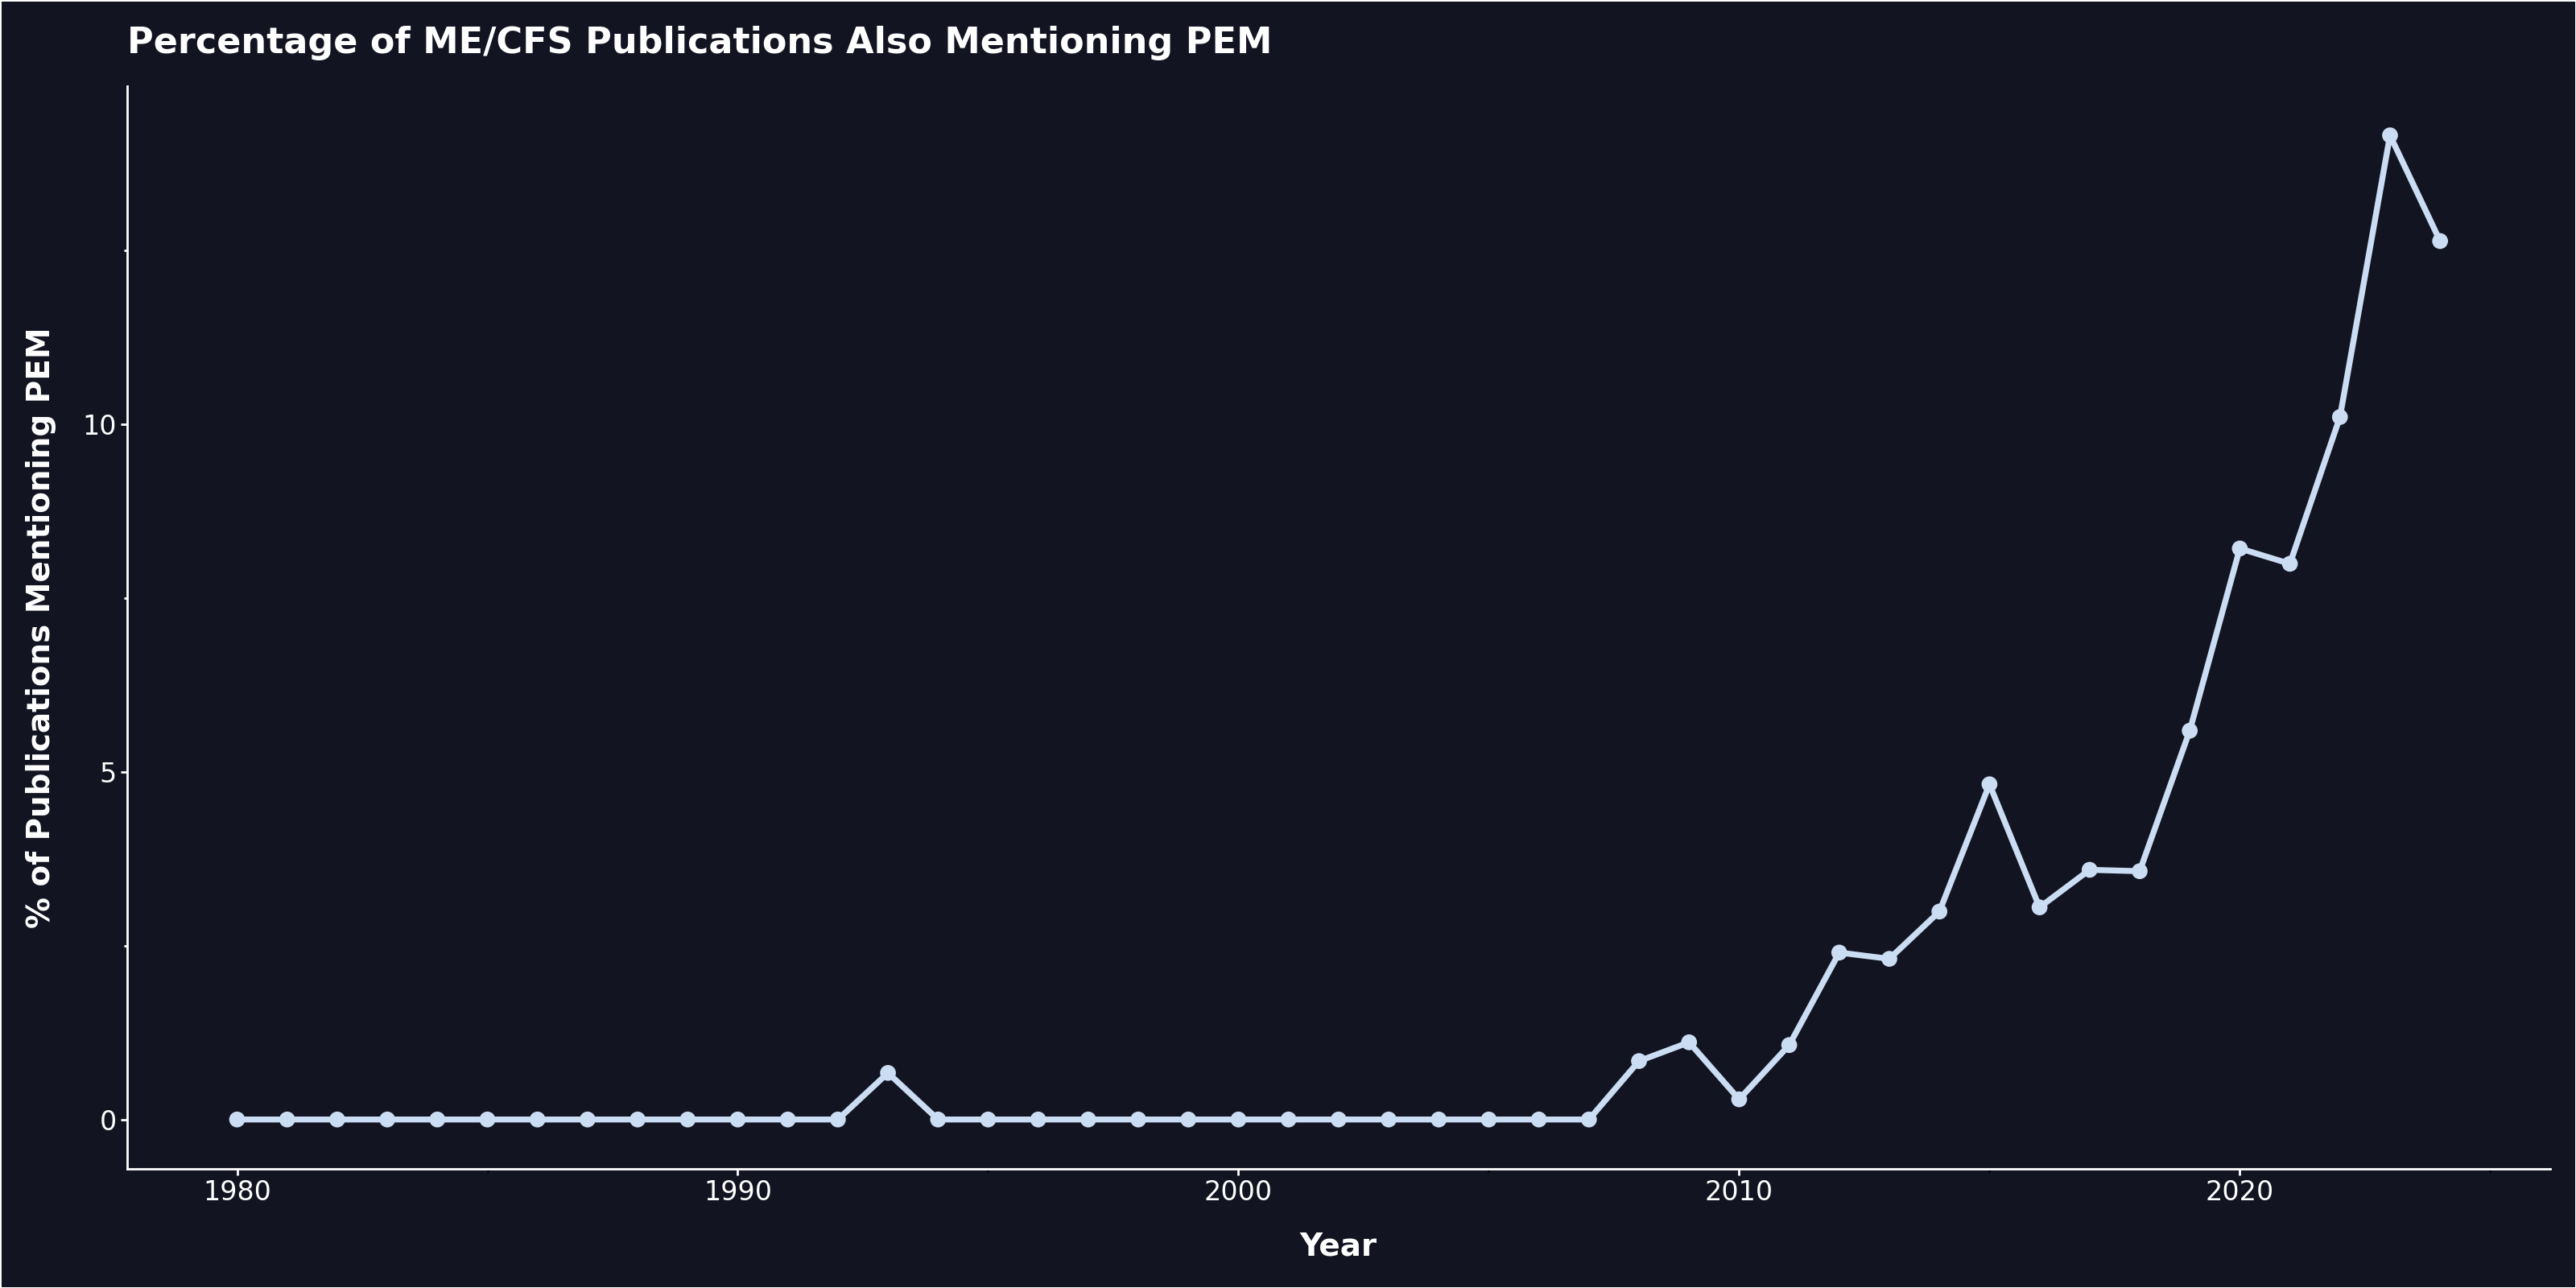

In [26]:
# Create line chart
plot = (
    ggplot(df_me, aes(x='Year', y='% Mentioning PEM'))
    + geom_line(color='#CBDDF3', size=1.5)  # Add line
    + geom_point(color='#CBDDF3', size=3)  # Add points for emphasis
    + labs(title='Percentage of ME/CFS Publications Also Mentioning PEM',
           x='Year',
           y='% of Publications Mentioning PEM')
    + theme_classic()
    + theme(
            figure_size=(16, 8),
            axis_title=element_text(size=14, weight='bold', color='white'),
            axis_text=element_text(size=12, color='white'),
            plot_title=element_text(size=16, weight='bold', color='white', hjust=0),
            legend_title=element_text(size=16, weight='bold', color='white'),
            legend_text=element_text(size=16, color='white'),
            plot_background=element_rect(fill='#121421', color=None),
            panel_background=element_rect(fill='#121421', color=None),
            legend_background=element_rect(fill='#121421', color=None),
            legend_key=element_rect(fill='#121421', color=None),
            axis_line=element_line(color='white', size=1),
            axis_ticks=element_line(color='white', size=1)
            )
)

# Display the plot
plot

#### 3.2 | % ME/CFS & LC Publications Mentioning PEM
---

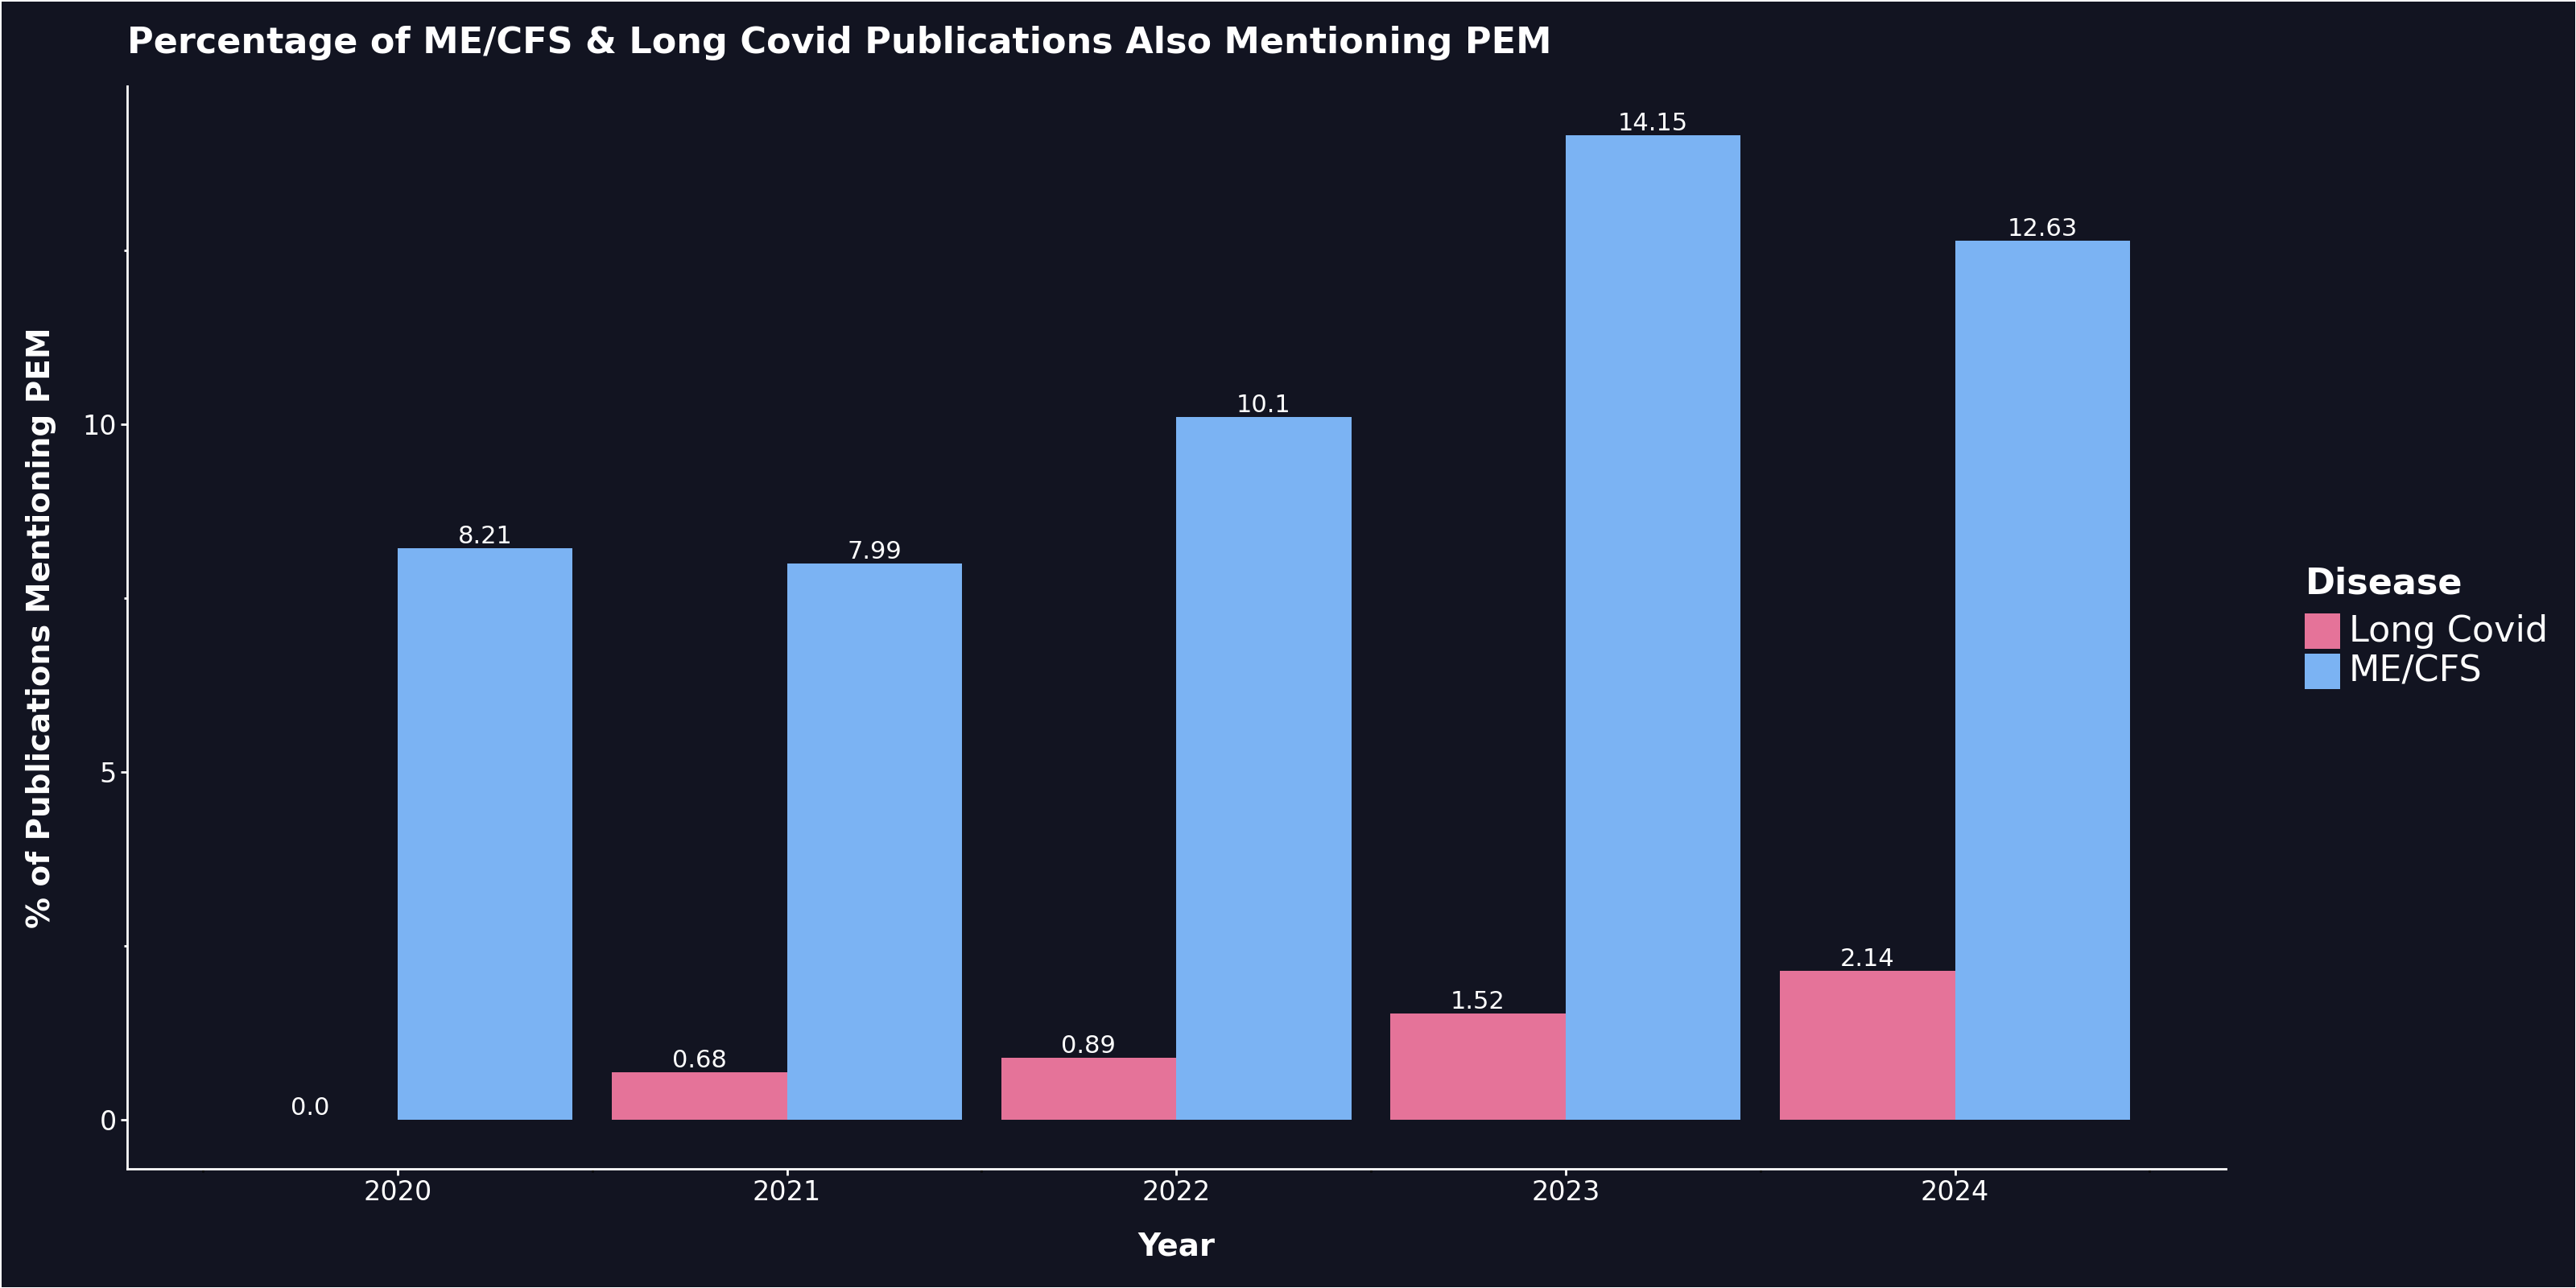

In [27]:
# Create plot
plot = (
    ggplot(df_lc_vs_me, aes(x='Year', y='% Mentioning PEM', fill='Disease'))
    + geom_bar(stat='identity', position='dodge')
    + geom_text(aes(label='% Mentioning PEM'), position=position_dodge(width=0.9), va='bottom', color='white')
    + labs(title='Percentage of ME/CFS & Long Covid Publications Also Mentioning PEM',
           x='Year', y='% of Publications Mentioning PEM', fill='Disease')
    + scale_fill_manual(values=['#E57399', '#7BB3F3'])
    + theme_classic()
    + theme(
            figure_size=(16, 8),
            axis_title=element_text(size=14, weight='bold', color='white'),
            axis_text=element_text(size=12, color='white'),
            plot_title=element_text(size=16, weight='bold', color='white', hjust=0),
            legend_title=element_text(size=16, weight='bold', color='white'),
            legend_text=element_text(size=16, color='white'),
            plot_background=element_rect(fill='#121421', color=None),
            panel_background=element_rect(fill='#121421', color=None),
            legend_background=element_rect(fill='#121421', color=None),
            legend_key=element_rect(fill='#121421', color=None),
            axis_line=element_line(color='white', size=1),
            axis_ticks=element_line(color='white', size=1)
            )
)

# Display the plot
plot